Batch shape: torch.Size([4, 8, 1, 128, 128])
CPU Time: 0.0199 sec
GPU Time: 0.0005 sec


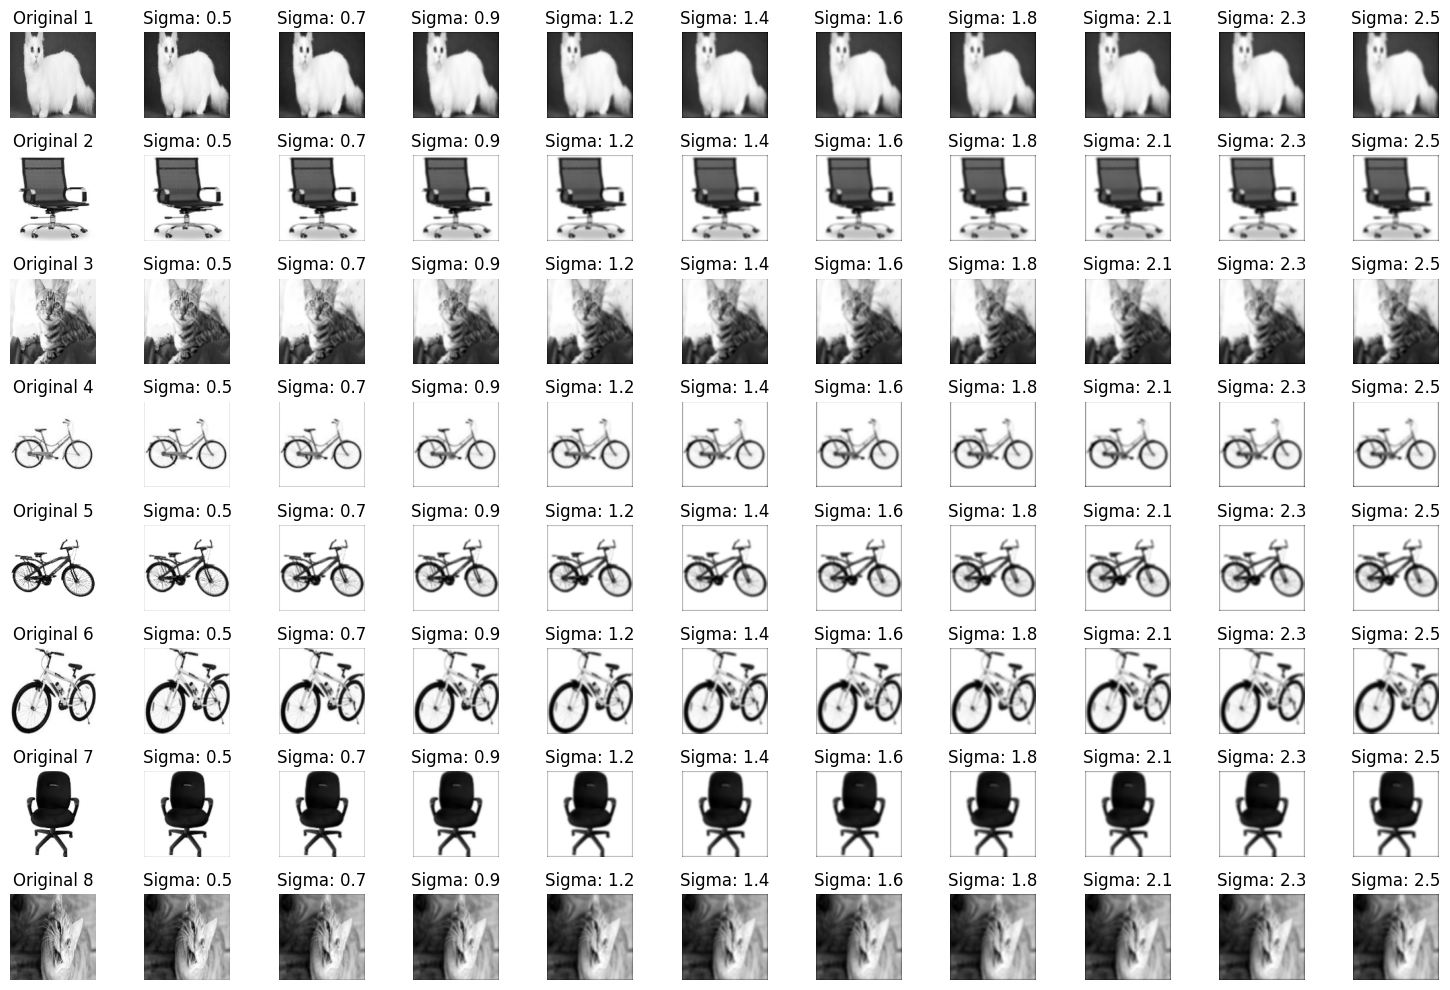

In [ ]:
import torch
import torch.nn.functional as F
import time
import numpy as np
import glob
import cv2
import matplotlib.pyplot as plt

# Load images from directory
def load_images(path, category):
    images = []
    for file in glob.glob(f'{path}/{category}*.jpg') + glob.glob(f'{path}/{category}*.jpeg'):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        if img is not None:
            img = cv2.resize(img, (128, 128))  # Resize to a fixed size (optional)
            images.append(img)
        else:
            print(f'Warning: Could not read {file}')
    return images

# Define data path
path = '/content/drive/MyDrive/bovwData'

# Load images from each category
cat_images = load_images(path, 'cat')
chair_images = load_images(path, 'chair')
cycle_images = load_images(path, 'cycle')  # New Class

# Normalize and convert to tensor
cat_images = torch.tensor(np.array(cat_images, dtype=np.float32) / 255.0).unsqueeze(1)
chair_images = torch.tensor(np.array(chair_images, dtype=np.float32) / 255.0).unsqueeze(1)
cycle_images = torch.tensor(np.array(cycle_images, dtype=np.float32) / 255.0).unsqueeze(1)

# Combine all images from all categories
all_images = torch.cat([cat_images, chair_images, cycle_images], dim=0)  # Concatenate along batch dimension

# Shuffle the images randomly
shuffled_indices = torch.randperm(all_images.size(0))  # Generate random indices
all_images = all_images[shuffled_indices]  # Shuffle the images

# Ensure the batch is divisible by batch size (optional)
batch_size = 8
all_images = all_images[:len(all_images) // batch_size * batch_size]  # Ensure divisibility
all_images_batches = all_images.view(-1, batch_size, 1, 128, 128)

# Check if we have the correct batch shape
print(f"Batch shape: {all_images_batches.shape}")

# Function to create Gaussian kernel
def create_gaussian_kernel(size, sigma):
    x = torch.arange(-size // 2 + 1, size // 2 + 1).float()
    y = x.view(-1, 1)
    kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

# Define Gaussian filter parameters
kernel_size = 5
sigmas = np.linspace(0.5, 2.5, 10)  # Different sigma values
gaussian_kernels = [create_gaussian_kernel(kernel_size, sigma) for sigma in sigmas]
gaussian_kernels = torch.stack(gaussian_kernels).unsqueeze(1)  # Shape: (10, 1, 5, 5)

# Function to apply filters using CPU
def apply_gaussian_cpu(images, kernels):
    batch_size, channels, height, width = images.shape
    output = []
    for kernel in kernels:
        kernel = kernel.repeat(channels, 1, 1, 1)  # Expand to match channels
        filtered = F.conv2d(images, kernel, padding=kernel_size//2)
        output.append(filtered)
    return torch.stack(output)

# Function to apply filters using GPU
def apply_gaussian_gpu(images, kernels):
    images, kernels = images.to("cuda"), kernels.to("cuda")
    kernels = kernels.repeat(1, images.shape[1], 1, 1)  # Match channels
    return F.conv2d(images, kernels, padding=kernel_size//2)

# Process images with CPU
cpu_times = []
for batch in all_images_batches:
    start = time.time()
    _ = apply_gaussian_cpu(batch, gaussian_kernels)
    cpu_times.append(time.time() - start)

# Process images with GPU
gpu_times = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    for batch in all_images_batches:
        batch = batch.to(device)
        start = time.time()
        _ = apply_gaussian_gpu(batch, gaussian_kernels)
        gpu_times.append(time.time() - start)

# Report execution times
print(f"CPU Time: {np.mean(cpu_times):.4f} sec")
if device.type == "cuda":
    print(f"GPU Time: {np.mean(gpu_times):.4f} sec")
else:
    print("GPU not available. Run on a machine with CUDA support.")

# Visualizing original and filtered images for the first batch
plt.figure(figsize=(15, 10))  # Adjust figure size for 8 images in a batch

# Plot original images (batch size 8)
for idx in range(batch_size):
    plt.subplot(batch_size, len(sigmas) + 1, idx * (len(sigmas) + 1) + 1)
    plt.imshow(all_images_batches[0][idx].squeeze().numpy(), cmap='gray')
    plt.title(f"Original {idx+1}")
    plt.axis('off')

# Apply filters and visualize for each sigma
for i, (kernel, sigma) in enumerate(zip(gaussian_kernels, sigmas), start=0):  # Start from 0 for proper sigma indexing
    filtered_image = apply_gaussian_cpu(all_images_batches[0], kernel.unsqueeze(0).unsqueeze(0))  # Apply each filter
    for idx in range(batch_size):
        plt.subplot(batch_size, len(sigmas) + 1, idx * (len(sigmas) + 1) + i + 2)  # Adjust index for sigma columns
        # Access the filtered image corresponding to each sigma and image in the batch
        plt.imshow(filtered_image[0, idx].squeeze().detach().numpy(), cmap='gray')  # Correct indexing: idx for image
        plt.title(f"Sigma: {sigma:.1f}")
        plt.axis('off')

plt.tight_layout()
plt.show()
